# Testing `numba`

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ March 30, 2023

This notebook tests the `numba` and how it might be used to speed-up our momentum distributions code.

_Last update:_ April 4, 2023

In [1]:
# Python imports
import matplotlib.pyplot as plt
from numba import njit, vectorize, float64
import numpy as np
from scipy.interpolate import interp1d
import vegas

In [2]:
# Imports from scripts
# ...

## Function that performs basic array operations

In [3]:
def function_1(x_array, quantum_numbers):
    """Basic function that calculates a 2-D array given a 1-D array."""

    integrand = 0
    for quantum_number in quantum_numbers:
        
        a, b, c = quantum_number
        integrand += np.sum(x_array) * a ** 2 * (2*b+1) / c
        
    return integrand

In [4]:
@njit
def numba_function_1(x_array, quantum_numbers):
    """Numba version of the above function."""

    integrand = 0
    for quantum_number in quantum_numbers:
        
        a, b, c = quantum_number
        integrand += np.sum(x_array) * a ** 2 * (2*b+1) / c
        
    return integrand

In [5]:
x_array = np.arange(1, 1001)
quantum_numbers = np.array([[3/2, 1, 1/2], [3/2, 1, -1/2], [3/2, 0, 1/2],
                            [3/2, 0, -1/2]])

In [6]:
%time y_array = function_1(x_array, quantum_numbers)

CPU times: user 132 µs, sys: 36 µs, total: 168 µs
Wall time: 158 µs


In [7]:
# COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
%time y_array = numba_function_1(x_array, quantum_numbers)

CPU times: user 206 ms, sys: 12.9 ms, total: 219 ms
Wall time: 218 ms


In [8]:
# Function is already compiled!
%time y_array = numba_function_1(x_array, quantum_numbers)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 7.87 µs


## Function that relies on interpolating functions

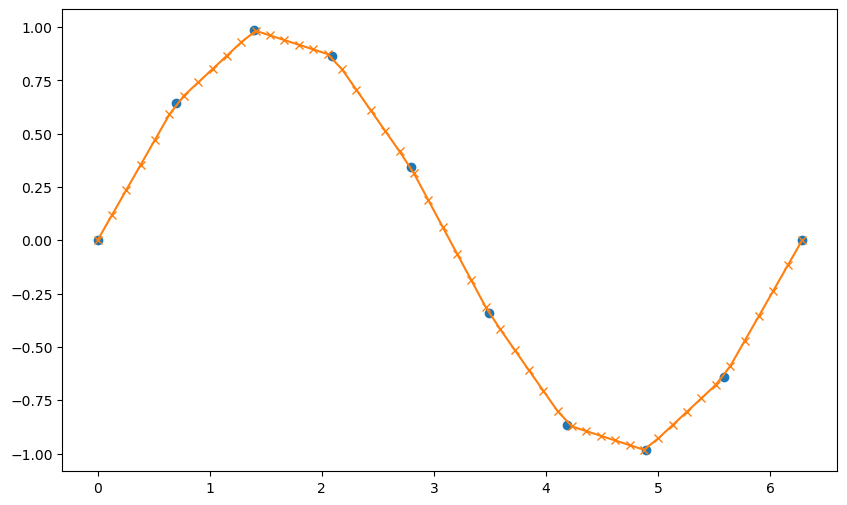

In [9]:
# Copied from https://stackoverflow.com/questions/62579492/interpolation-numba
@njit
def interp_nb(x_vals, x, y):
    return np.interp(xvals, x, y)

x = np.linspace(0, 2*np.pi, 10)
y = np.sin(x)
xvals = np.linspace(0, 2*np.pi, 50)

y_interp = interp_nb(xvals, x, y)

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o')
plt.plot(xvals, y_interp, '-x')

In [10]:
# # Try the above but with a scipy interpolation function like RectBivariateSpline
# @njit
# def interp_nb_2(x_vals, x, y):
#     y_func = interp1d(x, y, kind='cubic')
#     return y_func(xvals)

# x = np.linspace(0, 2*np.pi, 10)
# y = np.sin(x)
# xvals = np.linspace(0, 2*np.pi, 50)

# y_interp = interp_nb_2(xvals, x, y)

# plt.figure(figsize=(10,6))
# plt.plot(x, y, 'o')
# plt.plot(xvals, y_interp, '-x')

In [11]:
# # Try using @vectorize or @guvectorize on the interpolating function
# y_int = interp1d(x, y, kind='cubic')

# @vectorize([float64(float64)])
# def y_func(x_val):
#     return y_int(x_val)

# @njit
# def interp_nb_3(x_vals):
#     y_array = np.zeros_like(x_vals)
#     for i, x_val in enumerate(x_vals):
#         y_array[i] = y_func(x_val)
#     return y_array

# x = np.linspace(0, 2*np.pi, 10)
# y = np.sin(x)
# xvals = np.linspace(0, 2*np.pi, 50)

# y_interp = interp_nb_2(xvals, x, y)

# plt.figure(figsize=(10,6))
# plt.plot(x, y, 'o')
# plt.plot(xvals, y_interp, '-x')

Interpolation functions from `scipy` cannot be used within functions with the `@njit` decorator.

## Using `numba` and `vegas` simultaneously

In [12]:
def f(x):
    dx2 = 0
    for d in range(4):
        dx2 += (x[d] - 0.5) ** 2
    return np.exp(-dx2 * 100.) * 1013.2118364296088

In [13]:
def test_1():
    
    integ = vegas.Integrator([[-1, 1], [0, 1], [0, 1], [0, 1]])
    
    # Train the integrator
    integ(f, nitn=5, neval=1e3)
    # Final result
    result = integ(f, nitn=10, neval=1e4)

    print(result.summary())
    print('result = %s    Q = %.2f' % (result, result.Q))

In [14]:
# Run vegas example without numba
%time test_1()

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.9958(60)      0.9958(60)          0.00     1.00
  2   1.0068(48)      1.0025(38)          2.04     0.15
  3   1.0035(41)      1.0030(28)          1.03     0.36
  4   0.9997(35)      1.0017(22)          0.87     0.46
  5   1.0013(30)      1.0016(17)          0.65     0.62
  6   1.0003(26)      1.0012(14)          0.56     0.73
  7   1.0002(23)      1.0009(12)          0.48     0.82
  8   1.0011(19)      1.0010(10)          0.42     0.89
  9   0.9988(18)      1.00043(89)         0.50     0.86
 10   1.0018(15)      1.00079(77)         0.51     0.87

result = 1.00079(77)    Q = 0.87
CPU times: user 580 ms, sys: 1.9 ms, total: 582 ms
Wall time: 209 ms


In [15]:
@njit
def g(x):
    dx2 = 0
    for d in range(4):
        dx2 += (x[d] - 0.5) ** 2
    return np.exp(-dx2 * 100.) * 1013.2118364296088

In [16]:
def test_2():
    
    integ = vegas.Integrator([[-1, 1], [0, 1], [0, 1], [0, 1]])

    # Train the integrator
    integ(g, nitn=5, neval=1e3)
    # Final result
    result = integ(g, nitn=10, neval=1e4)
    
    print(result.summary())
    print('result = %s    Q = %.2f' % (result, result.Q))

In [17]:
# Run vegas example with numba
%time test_2()

itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.9951(66)      0.9951(66)          0.00     1.00
  2   0.9971(50)      0.9964(40)          0.06     0.81
  3   1.0000(43)      0.9981(29)          0.22     0.81
  4   1.0050(36)      1.0009(23)          0.90     0.44
  5   1.0019(30)      1.0012(18)          0.70     0.59
  6   1.0056(26)      1.0027(15)          0.94     0.45
  7   0.9994(23)      1.0017(12)          1.03     0.40
  8   1.0031(20)      1.0021(11)          0.93     0.48
  9   0.9991(18)      1.00134(91)         1.07     0.38
 10   1.0031(14)      1.00183(77)         1.06     0.39

result = 1.00183(77)    Q = 0.39
CPU times: user 67.5 ms, sys: 1.71 ms, total: 69.2 ms
Wall time: 68.6 ms
